In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract while preserving ALL paths exactly as they are in the zip
!mkdir -p /content/data_yawdd

In [ ]:
# This keeps every folder and subfolder exactly as in your zip
!unzip -q "/content/drive/MyDrive/YawDD_dataset.zip" -d /content/data_yawdd

In [ ]:
# data will be at: /content/data_yawdd/content/processed/YawDD/
!echo "Extraction complete with full structure preserved!"
!du -sh /content/data_yawdd
!find /content/data_yawdd -type d | head -15   # shows the folder tree

Extraction complete with full structure preserved!
1006M	/content/data_yawdd
/content/data_yawdd
/content/data_yawdd/content
/content/data_yawdd/content/processed
/content/data_yawdd/content/processed/YawDD
/content/data_yawdd/content/processed/YawDD/eyes
/content/data_yawdd/content/processed/YawDD/eyes/drowsy
/content/data_yawdd/content/processed/YawDD/eyes/alert
/content/data_yawdd/content/processed/YawDD/faces
/content/data_yawdd/content/processed/YawDD/faces/drowsy
/content/data_yawdd/content/processed/YawDD/faces/alert
/content/data_yawdd/content/processed/YawDD/mouth
/content/data_yawdd/content/processed/YawDD/mouth/drowsy
/content/data_yawdd/content/processed/YawDD/mouth/alert


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import pandas as pd

In [ ]:
DATA_ROOT = "/content/data_yawdd/content/processed/YawDD"

FACE_ALERT  = f"{DATA_ROOT}/faces/alert"
FACE_DROWSY = f"{DATA_ROOT}/faces/drowsy"
EYE_ALERT   = f"{DATA_ROOT}/eyes/alert"
EYE_DROWSY  = f"{DATA_ROOT}/eyes/drowsy"

In [ ]:
# loads face + both eyes
class TripleDrowsinessDataset(Dataset):
    def __init__(self, face_alert_dir, face_drowsy_dir, eye_alert_dir, eye_drowsy_dir, transform=None):
        self.data = []
        self.transform = transform

        # Alert samples
        alert_faces = os.listdir(face_alert_dir)
        fname_to_eyes = {}
        for eye_file in os.listdir(eye_alert_dir):
            if "_left" in eye_file:
                key = eye_file.replace("_left.jpg", "")
                fname_to_eyes[key] = eye_file.replace("_left.jpg", "")

        for face_file in alert_faces:
            key = face_file.replace(".jpg", "")
            if key in fname_to_eyes:
                self.data.append({
                    'face': os.path.join(face_alert_dir, face_file),
                    'left_eye': os.path.join(eye_alert_dir, key + "_left.jpg"),
                    'right_eye': os.path.join(eye_alert_dir, key + "_right.jpg"),
                    'label': 0
                })

        # Drowsy samples
        drowsy_faces = os.listdir(face_drowsy_dir)
        for face_file in drowsy_faces:
            key = face_file.replace(".jpg", "")
            left_path = os.path.join(eye_drowsy_dir, key + "_left.jpg")
            right_path = os.path.join(eye_drowsy_dir, key + "_right.jpg")
            if os.path.exists(left_path) and os.path.exists(right_path):
                self.data.append({
                    'face': os.path.join(face_drowsy_dir, face_file),
                    'left_eye': left_path,
                    'right_eye': right_path,
                    'label': 1
                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        face = Image.open(item['face']).convert('RGB')
        left_eye = Image.open(item['left_eye']).convert('RGB')
        right_eye = Image.open(item['right_eye']).convert('RGB')
        label = item['label']

        if self.transform:
            face = self.transform['face'](face)
            left_eye = self.transform['eye'](left_eye)
            right_eye = self.transform['eye'](right_eye)

        return face, left_eye, right_eye, torch.tensor(label)

In [ ]:
# TRANSFORMS
transform = {
    'face': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eye': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
dataset = TripleDrowsinessDataset(FACE_ALERT, FACE_DROWSY, EYE_ALERT, EYE_DROWSY, transform)

In [ ]:
def count_images(path):
    return len([f for f in os.listdir(path) if f.endswith(".jpg")])

eda_info = {
    "Face Alert": count_images(FACE_ALERT),
    "Face Drowsy": count_images(FACE_DROWSY),
    "Eye Alert": count_images(EYE_ALERT),
    "Eye Drowsy": count_images(EYE_DROWSY),
}

eda_df = pd.DataFrame.from_dict(eda_info, orient='index', columns=["Count"])
eda_df

,Count
Face Alert,27440
Face Drowsy,9084
Eye Alert,54880
Eye Drowsy,18168


In [ ]:
from collections import Counter

# Count the occurrences of each class label
class_counts = Counter(item['label'] for item in dataset.data)

print("Class Distribution:")
print(f"Alert (Label 0): {class_counts[0]} samples")
print(f"Drowsy (Label 1): {class_counts[1]} samples")

# Calculate and print percentages
total_samples = len(dataset.data)
print(f"Alert Percentage: { (class_counts[0] / total_samples) * 100:.2f}%")
print(f"Drowsy Percentage: { (class_counts[1] / total_samples) * 100:.2f}%")

Class Distribution:
Alert (Label 0): 27440 samples
Drowsy (Label 1): 9084 samples
Alert Percentage: 75.13%
Drowsy Percentage: 24.87%


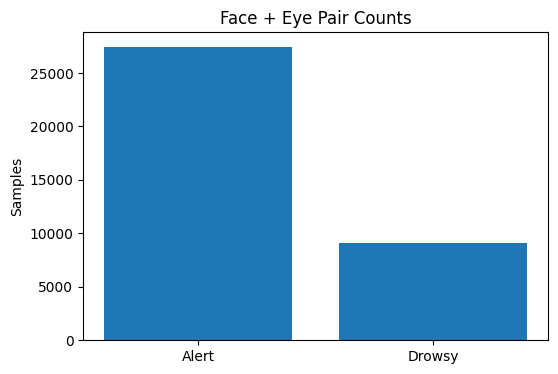

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(["Alert", "Drowsy"], [class_counts[0], class_counts[1]])
plt.title("Face + Eye Pair Counts")
plt.ylabel("Samples")
plt.show()

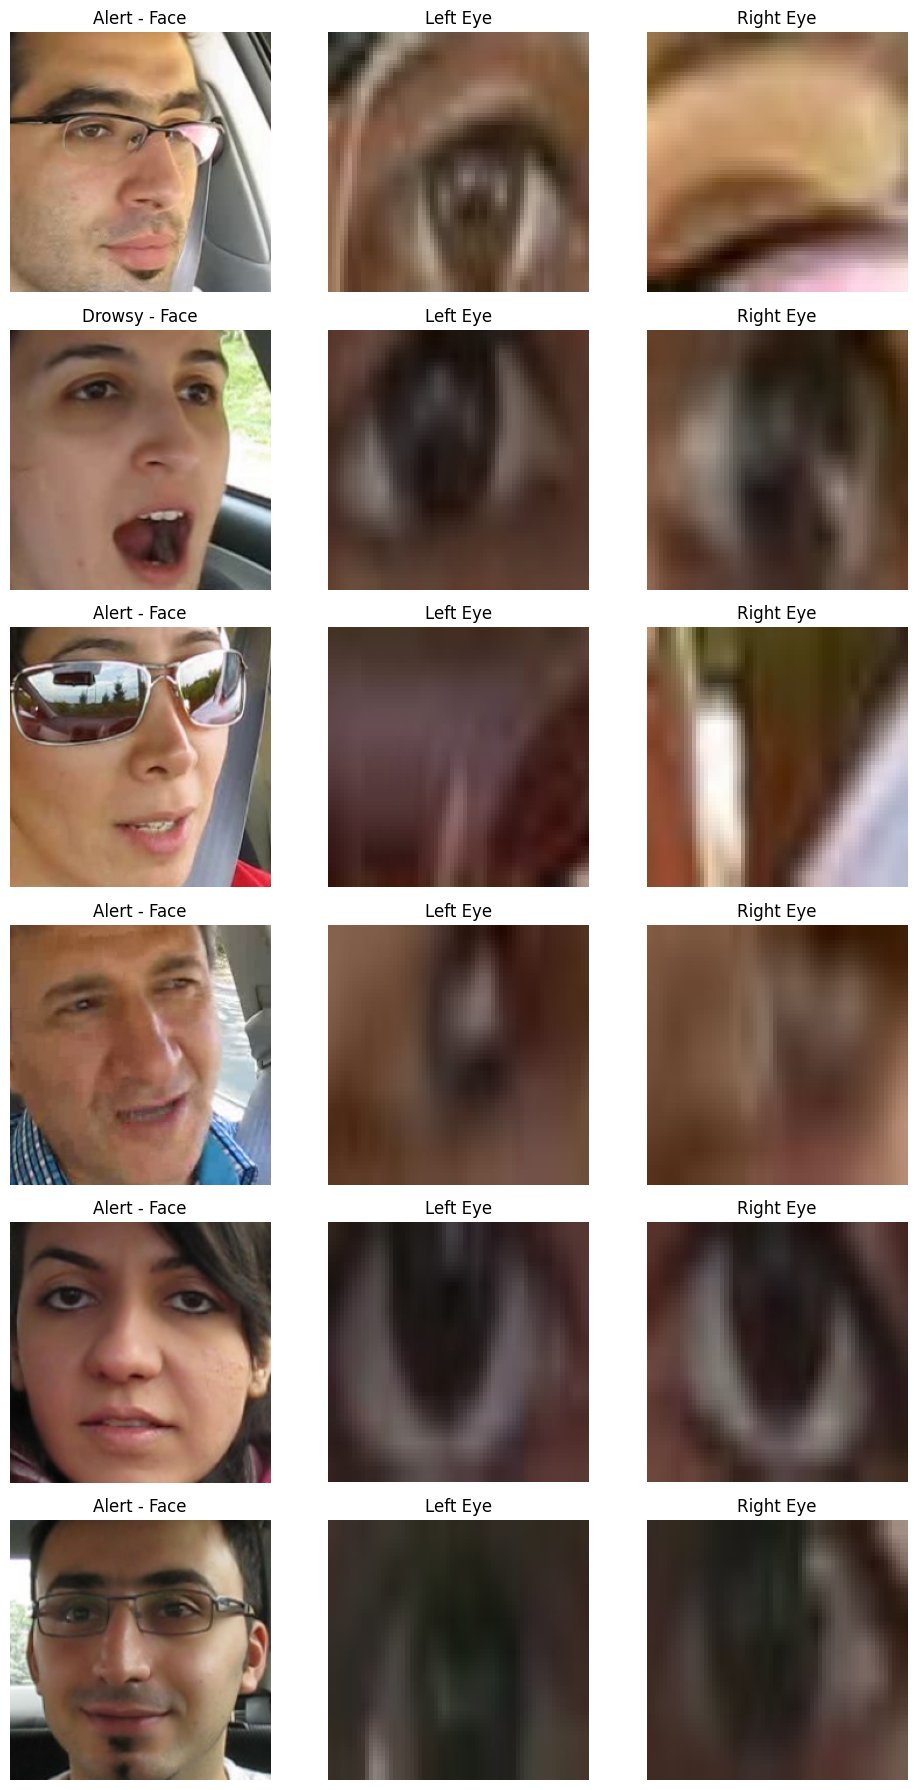

In [ ]:
def show_random_samples(n=4):
    samples = random.sample(dataset.data, n)
    fig, axes = plt.subplots(n, 3, figsize=(10, 3*n))

    for i, item in enumerate(samples):
        face = Image.open(item["face"]).convert("RGB")
        left_eye = Image.open(item["left_eye"]).convert("RGB")
        right_eye = Image.open(item["right_eye"]).convert("RGB")

        label = "Drowsy" if item["label"] == 1 else "Alert"

        axes[i][0].imshow(face)
        axes[i][0].set_title(f"{label} - Face")
        axes[i][0].axis('off')

        axes[i][1].imshow(left_eye)
        axes[i][1].set_title("Left Eye")
        axes[i][1].axis('off')

        axes[i][2].imshow(right_eye)
        axes[i][2].set_title("Right Eye")
        axes[i][2].axis('off')

    plt.tight_layout()
    plt.show()

show_random_samples(6)

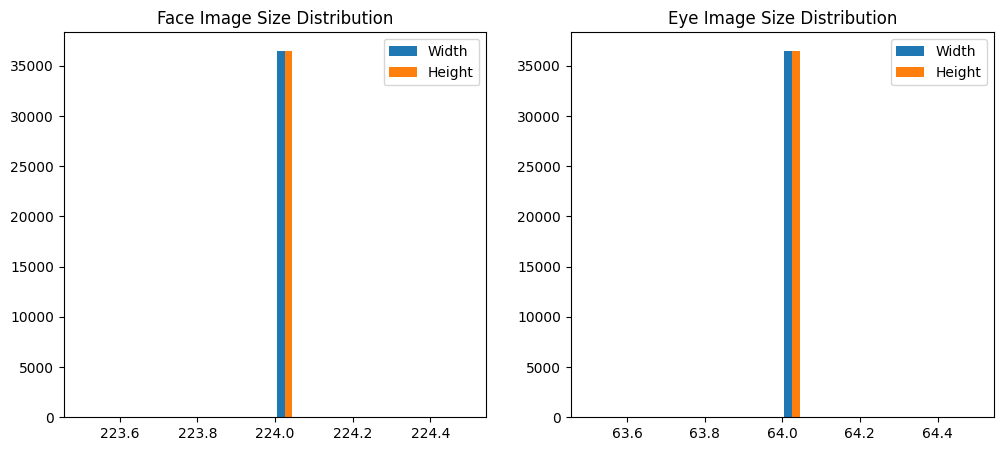

In [ ]:
face_sizes = []
eye_sizes = []

for item in dataset.data:
    face_sizes.append(Image.open(item['face']).size)
    eye_sizes.append(Image.open(item['left_eye']).size)

face_w = [w for w,h in face_sizes]
face_h = [h for w,h in face_sizes]

eye_w = [w for w,h in eye_sizes]
eye_h = [h for w,h in eye_sizes]

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].hist([face_w, face_h], label=["Width","Height"], bins=20)
ax[0].set_title("Face Image Size Distribution")
ax[0].legend()

ax[1].hist([eye_w, eye_h], label=["Width","Height"], bins=20)
ax[1].set_title("Eye Image Size Distribution")
ax[1].legend()

plt.show()

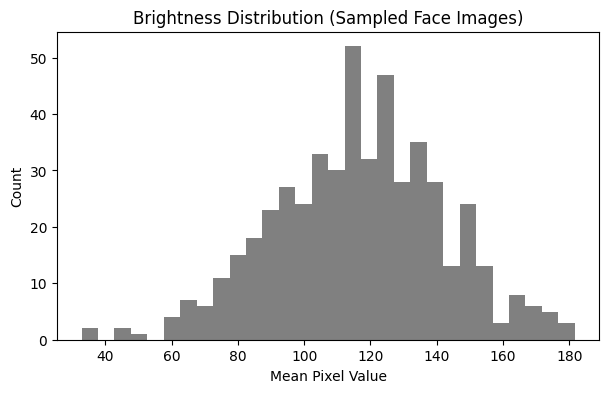

In [ ]:
brightness_values = []

for item in random.sample(dataset.data, 500):  # sample 500 images for speed
    img = Image.open(item['face']).convert("L")
    brightness_values.append(np.array(img).mean())

plt.figure(figsize=(7,4))
plt.hist(brightness_values, bins=30, color="gray")
plt.title("Brightness Distribution (Sampled Face Images)")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Count")
plt.show()


In [ ]:
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# ------------------- MODEL (EXACT SAME AS FINAL PROJECT) -------------------
class DrowsinessCNN(nn.Module):
    def __init__(self):
        super(DrowsinessCNN, self).__init__()

        # Face branch - ResNet18
        resnet = models.resnet18(pretrained=True)
        self.face_branch = nn.Sequential(*list(resnet.children())[:-2])  # remove avgpool & fc
        self.face_pool = nn.AdaptiveAvgPool2d((1,1))

        # Eye branch - smaller CNN (same as original)
        self.eye_branch = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 + 256 + 256, 512),  # face 512 + left 256 + right 256
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, face, left_eye, right_eye):
        # Face
        f = self.face_branch(face)
        f = self.face_pool(f).view(f.size(0), -1)  # (B, 512)

        # Left eye
        l = self.eye_branch(left_eye).view(left_eye.size(0), -1)  # (B, 256)

        # Right eye
        r = self.eye_branch(right_eye).view(right_eye.size(0), -1)  # (B, 256)

        # Concatenate
        x = torch.cat((f, l, r), dim=1)  # (B, 1024)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DrowsinessCNN().to(device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.5]).to(device))  # extra weight on drowsy
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-6)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


In [ ]:
best_acc = 0.0
train_losses = []
val_accuracies = []
val_losses = []
num_epoch = 50
print(f"Starting training for {num_epoch} epochs \n")

for epoch in range(num_epoch):
    # Train
    model.train()
    running_loss = 0.0
    for faces, left_eyes, right_eyes, labels in train_loader:
        faces, left_eyes, right_eyes, labels = faces.to(device), left_eyes.to(device), right_eyes.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(faces, left_eyes, right_eyes)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Val
    model.eval()
    val_running_loss = 0.0
    correct = total = 0
    with torch.no_grad():
        for faces, left_eyes, right_eyes, labels in val_loader:
            faces, left_eyes, right_eyes, labels = faces.to(device), left_eyes.to(device), right_eyes.to(device), labels.to(device)
            outputs = model(faces, left_eyes, right_eyes)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, pred = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    acc = 100 * correct / total
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1:2d} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {acc:.2f}%")

    scheduler.step(acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/drowsiness_model.pth")
        print(" → NEW BEST MODEL SAVED!")

Starting training for 50 epochs 

Epoch  1 | Train Loss: 0.5457 | Val Loss: 0.4738 | Val Acc: 80.87%
 → NEW BEST MODEL SAVED!
Epoch  2 | Train Loss: 0.3985 | Val Loss: 0.4624 | Val Acc: 70.58%
Epoch  3 | Train Loss: 0.3034 | Val Loss: 0.3105 | Val Acc: 85.14%
 → NEW BEST MODEL SAVED!
Epoch  4 | Train Loss: 0.1830 | Val Loss: 0.2072 | Val Acc: 93.06%
 → NEW BEST MODEL SAVED!
Epoch  5 | Train Loss: 0.1720 | Val Loss: 0.2462 | Val Acc: 88.74%
Epoch  6 | Train Loss: 0.0941 | Val Loss: 0.1569 | Val Acc: 94.93%
 → NEW BEST MODEL SAVED!
Epoch  7 | Train Loss: 0.1145 | Val Loss: 0.1695 | Val Acc: 93.78%
Epoch  8 | Train Loss: 0.1207 | Val Loss: 0.2138 | Val Acc: 93.81%
Epoch  9 | Train Loss: 0.1121 | Val Loss: 0.2177 | Val Acc: 95.22%
 → NEW BEST MODEL SAVED!
Epoch 10 | Train Loss: 0.0557 | Val Loss: 0.1676 | Val Acc: 94.83%
Epoch 11 | Train Loss: 0.0627 | Val Loss: 0.1766 | Val Acc: 94.36%
Epoch 12 | Train Loss: 0.0597 | Val Loss: 0.1936 | Val Acc: 94.47%
Epoch 13 | Train Loss: 0.0641 | Val L

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/drowsiness_final_best_state_dict.pth")
torch.save(model, "/content/drive/MyDrive/drowsiness_full_model.pt")

print("FINAL MODELS SAVED CORRECTLY!")

FINAL MODELS SAVED CORRECTLY!


In [ ]:
torch.save(model.state_dict(), "/content/drowsiness-97_13.pth")
torch.save(model, "/content/drowsiness-97_13.pt")

print("FINAL MODELS SAVED CORRECTLY!")

FINAL MODELS SAVED CORRECTLY!


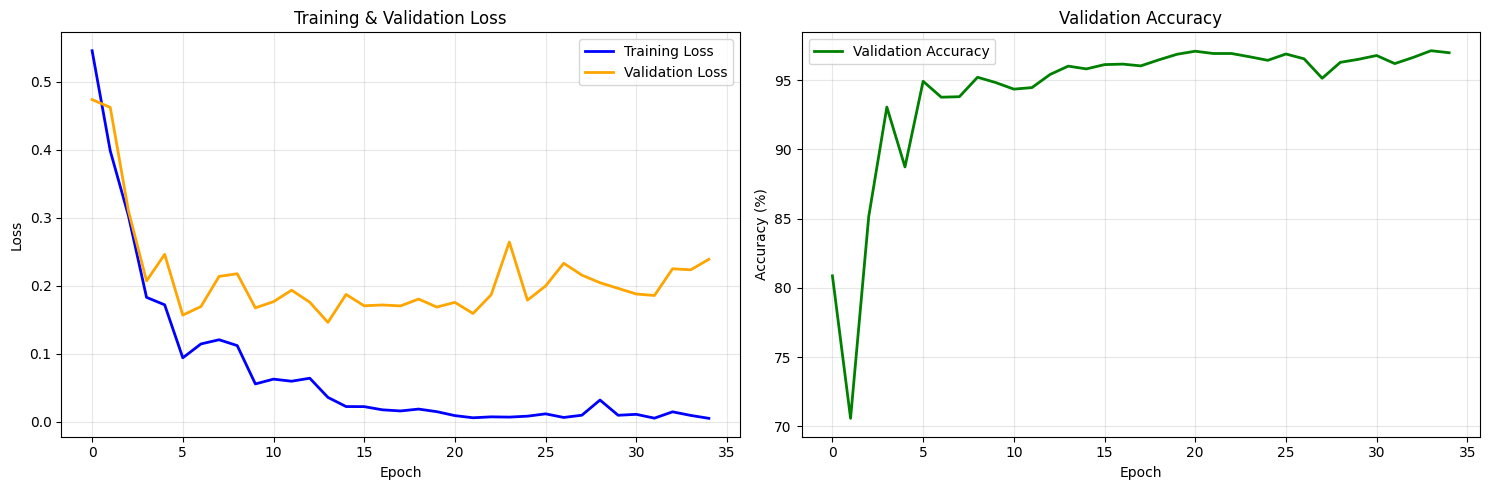

In [ ]:
# ======================= PLOTTING (run this after training) =======================
plt.figure(figsize=(15, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linewidth=2)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
model.eval()
all_images = []
all_labels = []
all_preds = []

# Collect all predictions from validation set
with torch.no_grad():
    for faces, left_eyes, right_eyes, labels in val_loader:
        faces, left_eyes, right_eyes = faces.to(device), left_eyes.to(device), right_eyes.to(device)
        outputs = model(faces, left_eyes, right_eyes)
        preds = outputs.argmax(dim=1).cpu().numpy()
        # all_preds.extend(preds)
        # all_labels.extend(labels.cpu().numpy())

        for i in range(len(preds)):
            all_images.append(faces[i].cpu())
            all_labels.append(labels[i])
            all_preds.append(preds[i])

In [ ]:
print(all_images[1])

tensor([[[-0.7822, -0.7993, -0.9020,  ..., -2.0152, -2.0152, -2.0152],
         [-0.7822, -0.7993, -0.8678,  ..., -2.0152, -2.0323, -2.0323],
         [-0.7650, -0.8164, -0.8678,  ..., -2.0152, -2.0152, -1.9980],
         ...,
         [ 0.0912,  0.0912,  0.0912,  ..., -1.4672, -1.5014, -1.5185],
         [ 0.1426,  0.1597,  0.1768,  ..., -1.7240, -1.7754, -1.8097],
         [ 0.1939,  0.2111,  0.2453,  ..., -1.8439, -1.8782, -1.8953]],

        [[-0.9853, -1.0203, -1.0553,  ..., -1.9307, -1.9132, -1.9132],
         [-0.9853, -1.0203, -1.0553,  ..., -1.9307, -1.9307, -1.9307],
         [-1.0028, -1.0378, -1.0553,  ..., -1.9307, -1.9307, -1.9132],
         ...,
         [ 0.2227,  0.2227,  0.2577,  ..., -1.4230, -1.4580, -1.4755],
         [ 0.2752,  0.2927,  0.3102,  ..., -1.6681, -1.7381, -1.7731],
         [ 0.3277,  0.3452,  0.3803,  ..., -1.8081, -1.8081, -1.8256]],

        [[-0.9330, -0.9504, -1.0027,  ..., -1.6999, -1.6650, -1.6650],
         [-0.9330, -0.9504, -1.0027,  ..., -1

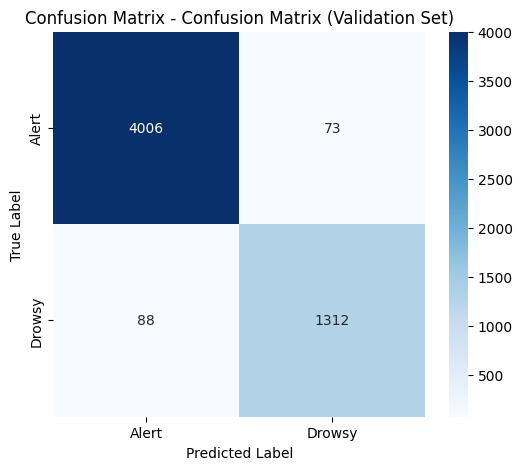

              precision    recall  f1-score   support

       Alert       0.98      0.98      0.98      4079
      Drowsy       0.95      0.94      0.94      1400

    accuracy                           0.97      5479
   macro avg       0.96      0.96      0.96      5479
weighted avg       0.97      0.97      0.97      5479



In [ ]:
# ==================== FINAL EVALUATION ON VALIDATION SET ====================
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alert', 'Drowsy'], yticklabels=['Alert', 'Drowsy'])
plt.title('Confusion Matrix - Confusion Matrix (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=['Alert', 'Drowsy']))

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)

print("Per-class Metrics on Validation Set:")
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1-Score'}")
print("-" * 40)
print(f"{'Alert':<10} {precision[0]:.4f}     {recall[0]:.4f}     {f1[0]:.4f}")
print(f"{'Drowsy':<10} {precision[1]:.4f}     {recall[1]:.4f}     {f1[1]:.4f}")

Per-class Metrics on Validation Set:
Class      Precision  Recall     F1-Score
----------------------------------------
Alert      0.9785     0.9821     0.9803
Drowsy     0.9473     0.9371     0.9422


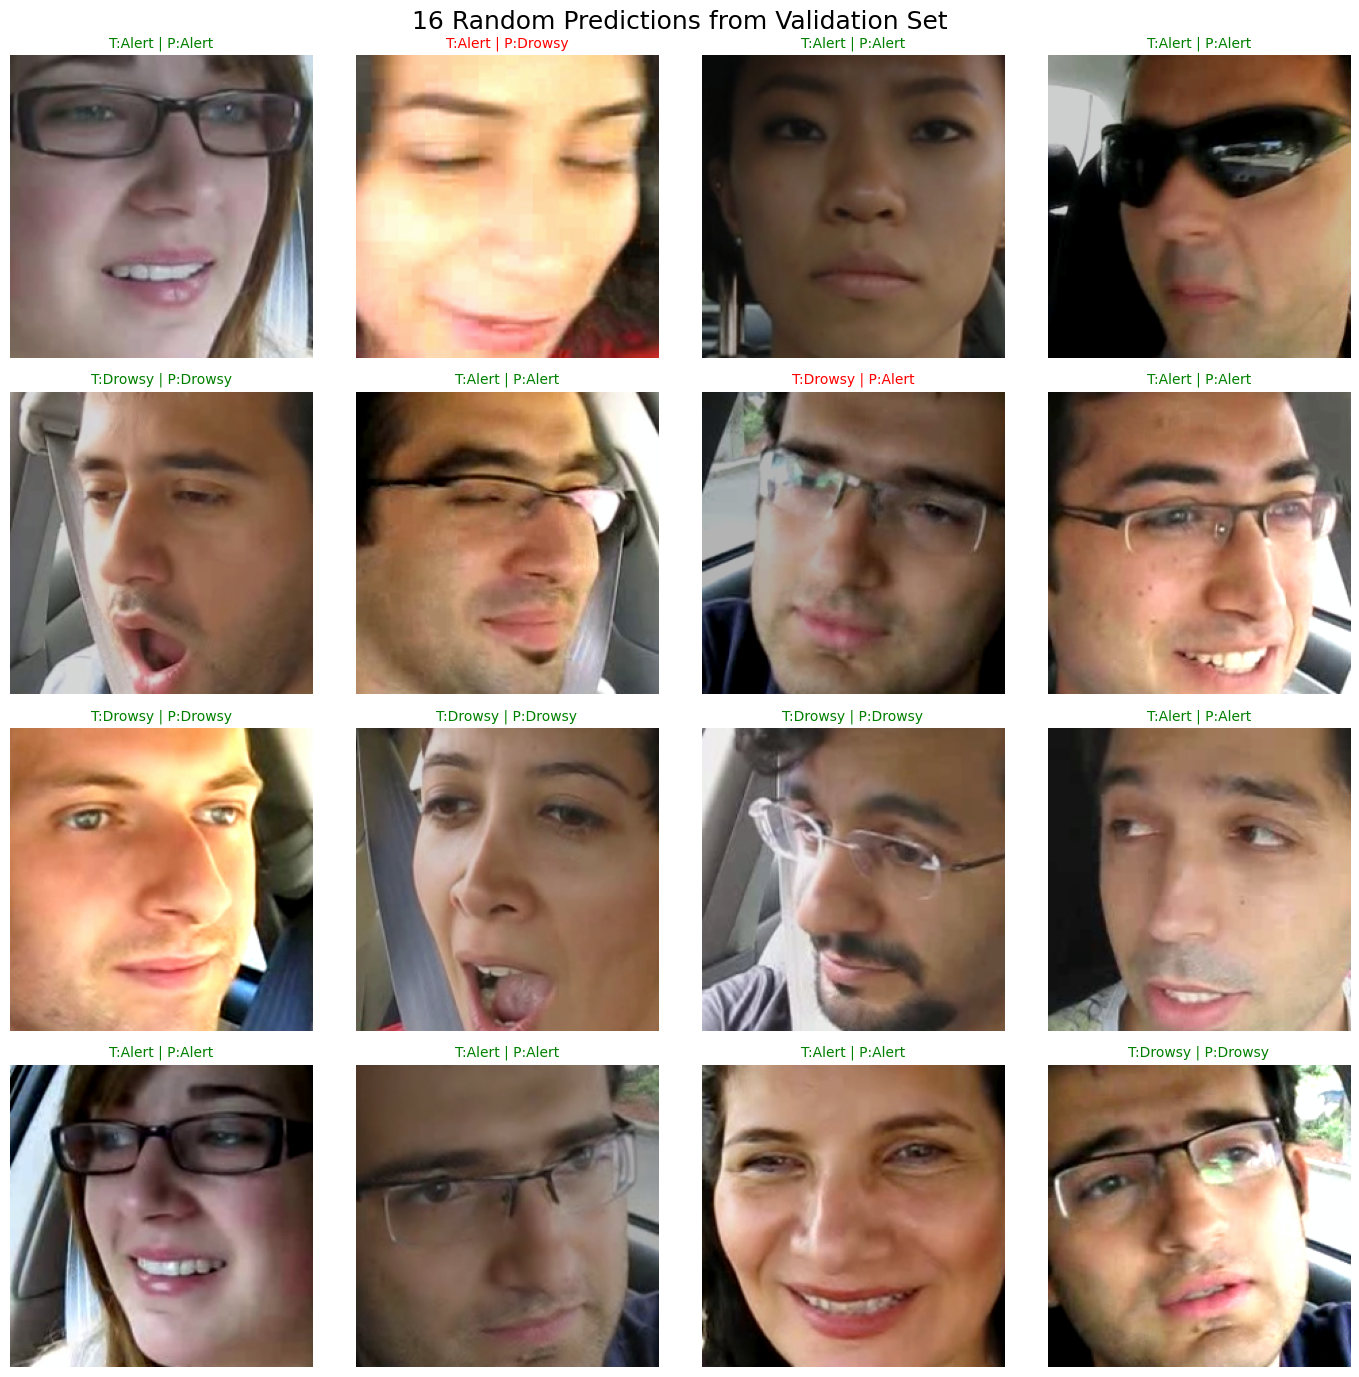

In [ ]:
# 16 random samples
indices = random.sample(range(len(all_images)), 16)

fig, axes = plt.subplots(4, 4, figsize=(14, 14))
fig.suptitle("16 Random Predictions from Validation Set", fontsize=18)

axes = axes.flatten()  # flatten 2D array

for idx, ax in zip(indices, axes):

    img = all_images[idx].permute(1, 2, 0).numpy()
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)

    true_label = "Drowsy" if all_labels[idx] == 1 else "Alert"
    pred_label = "Drowsy" if all_preds[idx] == 1 else "Alert"

    color = "green" if true_label == pred_label else "red"

    ax.imshow(img)
    ax.set_title(f"T:{true_label} | P:{pred_label}", color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from torchsummary import summary
summary(model, input_size=[(3,224,224), (3,64,64), (3,64,64)])  # install: !pip install torchsummary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,